<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

# 1. SINDy (sparse identification of the non-linear dynamics) in Groud Truth Coordinates z

1.1 Simulation


In [2]:
# Define the pendulum_rhs function
def pendulum_rhs(z, dzdt, coefficients, terms):
    return np.dot(terms(z), coefficients)

In [3]:
# Define the pendulum_ode_step function
def pendulum_ode_step(y, t, coefficients, terms):
    D = len(y) // 2
    z_values = y[:D]
    dzdt_values = y[D:]

    # Evaluate rhs using the current terms
    rhs = pendulum_rhs(z_values, dzdt_values, coefficients, terms)

    # Check if rhs is 1-dimensional or 2-dimensional
    if np.ndim(rhs) == 1:
        dydt = np.concatenate([dzdt_values, rhs])
    else:
        dydt = np.concatenate([dzdt_values, rhs[1]])

    return dydt

In [4]:
# Function to simulate the pendulum using odeint
def simulate_pendulum(y0, coefficients, terms, T, dt):
    # Call odeint with the pendulum_ode_step function
    result = odeint(pendulum_ode_step, y0, np.arange(0, T, dt), args=(coefficients, terms))

    return result

(100, 2)
(100, 1)


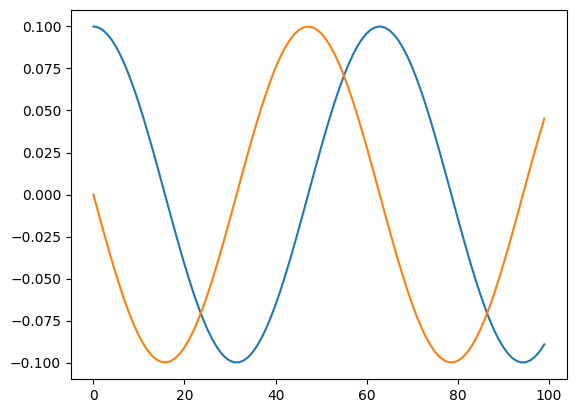

In [5]:
# checking something
D = 1
L = 1
z0 = np.array([0.1])
dz0 = np.array([0.0])
coefficients = np.array([[-1.0]])

# Define terms as a vector of functions (sine function in this case)
terms = lambda z: np.sin(z)

T = 10.0
dt = 0.1
y0 = np.concatenate([z0, dz0])

result = simulate_pendulum(y0, coefficients, terms, T, dt)
plt.plot(result); print(np.shape(result)); print(np.shape(result[:,:D]))

In [6]:
def create_pendulum_data(z0_min, z0_max,
                         dz0_min, dz0_max,
                         coefficients, terms,
                         T, dt, N,
                         embedding=None, rejection=True, Dim=1):
    data_dict = {}

    for sim_run_num in tqdm(range(N), desc="Simulations"):
        while True:
            z0 = np.array([np.random.uniform(z0_min, z0_max)])
            dz0 = np.array([np.random.uniform(dz0_min, dz0_max)])

            if not rejection:
                break  # No rejection, proceed with the simulation

            angular_momentum = 0.5 * (dz0 ** 2) - np.cos(z0)
            #print("angular_momentum", np.abs(angular_momentum))

            if np.abs(angular_momentum) <= 0.99:
                break  # Angular momentum condition satisfied, proceed with the simulation

        simulation_result = simulate_pendulum(np.concatenate([z0, dz0]), coefficients, terms, T, dt)
        # D=np.shape(simulation_result)[1]//2
        # print("Dim is:", Dim)
        second_derivative = pendulum_rhs(simulation_result[:,:Dim], simulation_result[:,Dim:],
                                         coefficients, terms)

        if embedding is not None:
            # Add code for artificial embedding (needed later)
            pass

        data_dict[sim_run_num+1]={"z":simulation_result[:, :Dim],
                                  "dzdt":simulation_result[:, Dim:],
                                  "d2zdt":second_derivative}

        #data.append((simulation_result[:, :Dim], simulation_result[:, Dim:], second_derivative))#[D:]))

    return data_dict



In [7]:
z0_min = -np.pi
z0_max = np.pi
dz0_min = -2.1
dz0_max = 2.1
coefficients = np.array([[-1.0]])
terms = lambda z: np.sin(z)

T = 50.0
dt = 0.02
N =  100# number of simulation runs
embedding = None
rejection = True

training_data_dict = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max,
                                     coefficients, terms, T, dt, N, embedding, rejection)

time=np.arange(0,T,step=dt)

# print("training_data dict:")
# print(training_data_dict)

Simulations: 100%|██████████| 100/100 [00:02<00:00, 47.97it/s]


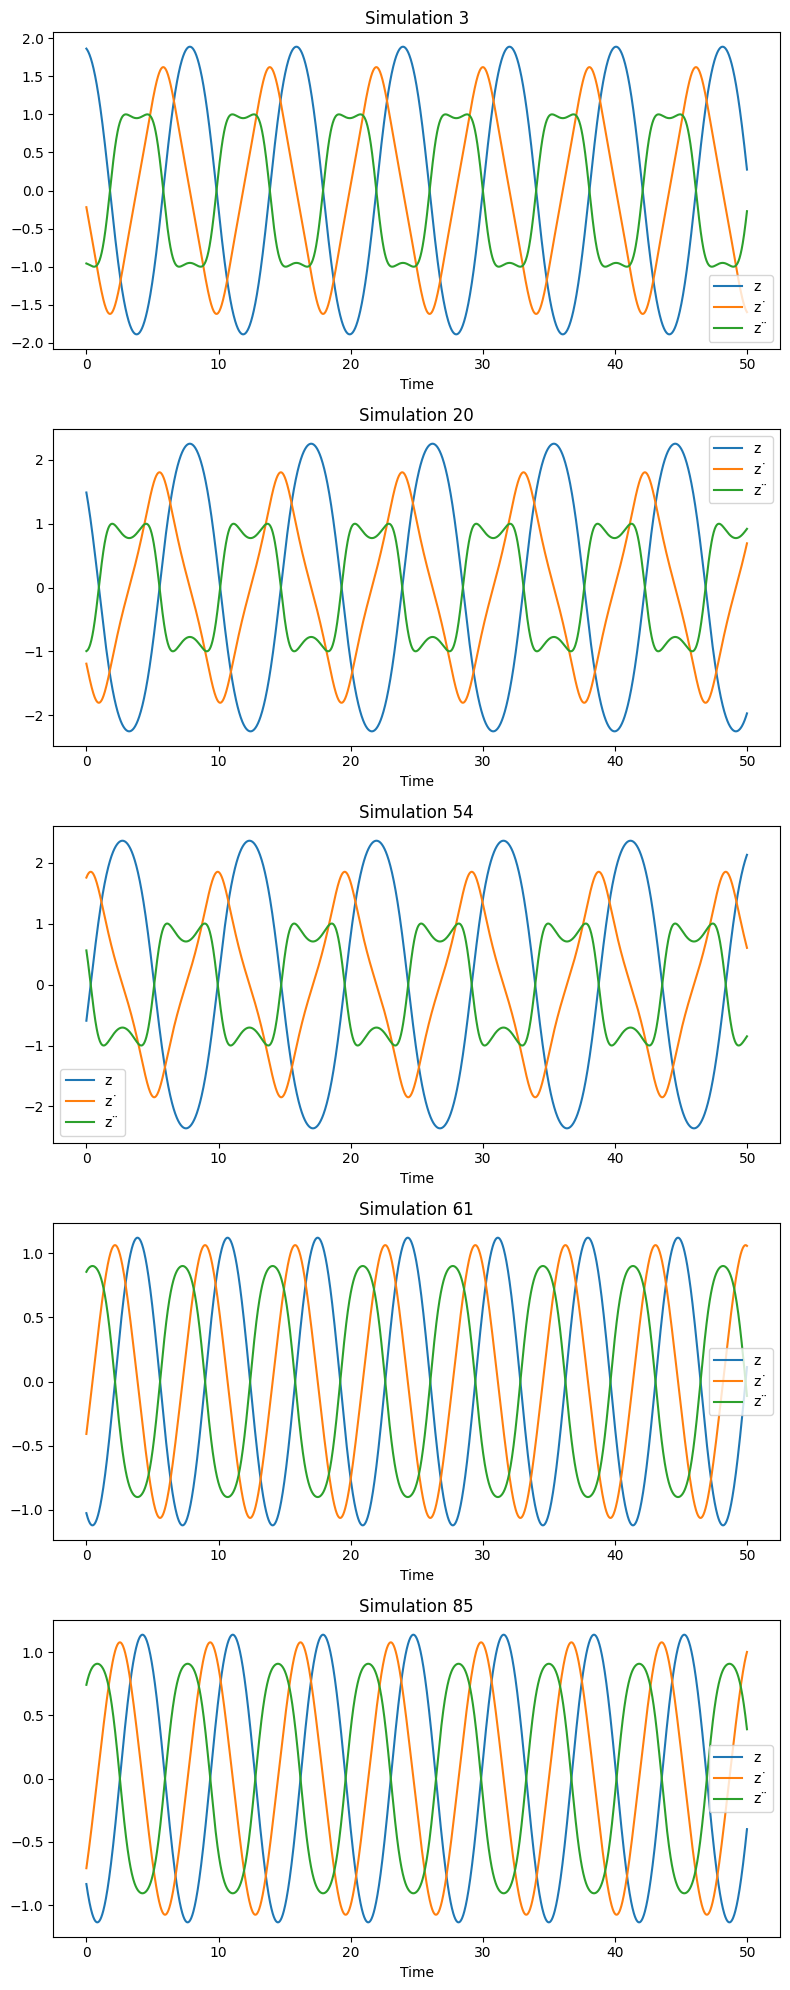

In [8]:
import matplotlib.pyplot as plt

# Choose 5 simulations randomly
selected_simulations = np.random.choice(N, 5, replace=False)

# Plot the selected simulations
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

for i, sim_num in enumerate(selected_simulations):
    time_points = np.arange(0, T, step=dt)  # Assuming 'time' is not included in data_dict
    z_values = training_data_dict[sim_num+1]['z']  # zt
    dzdt_values = training_data_dict[sim_num+1]['dzdt']  # z˙t
    d2zdt_values = training_data_dict[sim_num+1]['d2zdt']  # z¨t

    # Plot z, z˙, and z¨ on the same plot
    axs[i].plot(time_points, z_values, label='z')
    axs[i].plot(time_points, dzdt_values, label='z˙')
    axs[i].plot(time_points, d2zdt_values, label='z¨')
    axs[i].set_title(f'Simulation {sim_num + 1}')
    axs[i].set_xlabel('Time')
    axs[i].legend()

plt.tight_layout()
plt.show()




Creating the training data-set

In [9]:
# Extract arrays for "z", "dzdt", and "d2zdt"
z_arrays = [v["z"] for v in training_data_dict.values()]
dzdt_arrays = [v["dzdt"] for v in training_data_dict.values()]
d2zdt_arrays = [v["d2zdt"] for v in training_data_dict.values()]

# print(z_arrays)

# Concatenate along the first axis
concatenated_z = np.concatenate(z_arrays, axis=0)
concatenated_dzdt = np.concatenate(dzdt_arrays, axis=0)
concatenated_d2zdt = np.concatenate(d2zdt_arrays, axis=0)


print("Concatenated z:")
print(concatenated_z.shape) # number of datapoints (T*N,1)

Concatenated z:
(250000, 1)


1.2 Implementation and Training

In [10]:
def sin_term(z):
    return np.sin(z)

def cos_term(z):
    return np.cos(z)

def square(z):
  return z*z

def z_times_dzdt(z,dzdt):
  return z * dzdt


def term_vector(z,dzdt):
  to_return= np.array([np.ones(np.shape(z)), z, dzdt, sin_term(z),
                   square(z), z_times_dzdt(z,dzdt),
                   z*sin_term(z), square(dzdt),
                   dzdt * sin_term(z),
                   sin_term(z)*sin_term(z)
                   ])

  return to_return

In [11]:
# Creating the X matrix for the lasso regression

flattened_z = concatenated_z.flatten()
flattened_dzdt = concatenated_dzdt.flatten()

result = term_vector(flattened_z, flattened_dzdt)
# right now our X matrix (for Lasso) is of the shape (number of features X number of datapoints)
# let transpose it so that the shape of X matrix (for lasso) is (number of datapoints X no. of features)
X_for_regression=np.transpose(result)
print("X for regression is:")
print(X_for_regression); print(X_for_regression.shape); print(concatenated_z.shape)

X for regression is:
[[ 1.         -0.21850834 -1.86082833 ...  3.46268209  0.40337859
   0.04699083]
 [ 1.         -0.25567915 -1.85613088 ...  3.44522184  0.4694202
   0.06395969]
 [ 1.         -0.2927488  -1.85071521 ...  3.4251468   0.53408895
   0.0832814 ]
 ...
 [ 1.          0.28769798  1.10685237 ...  1.22512216  0.31406446
   0.08051155]
 [ 1.          0.30977687  1.10096602 ...  1.21212619  0.33562524
   0.09293116]
 [ 1.          0.33173383  1.09466029 ...  1.19828114  0.35651204
   0.10606929]]
(250000, 10)
(250000, 1)


In [12]:
# creating training and the test set
X_train, X_test, y_train, y_test = train_test_split(X_for_regression,concatenated_d2zdt,
                                                    test_size=0.3,random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((175000, 10), (75000, 10), (175000, 1), (75000, 1))

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDataset for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Set batch size for training and test DataLoader
batch_size = 32

# Create DataLoader for training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for test set
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

implementing SINDy using sklearn's LASSO

In [15]:
### checking the weights using the lasso regression
from sklearn.linear_model import Lasso

# Create Lasso model
lasso = Lasso(alpha=0.001, fit_intercept=False)

# Fit the model
lasso.fit(X_train, y_train)

# Access coefficients and intercept
coefficients = lasso.coef_
# intercept = lasso.intercept_

print("Coefficients:", coefficients)
# print("Intercept:", intercept)

Coefficients: [-0.         -0.00239636  0.         -0.99423501 -0.         -0.
 -0.         -0.         -0.         -0.        ]


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = lasso.predict(X_test)

# Evaluate the performance using different metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 3.569509469028961e-06
Mean Absolute Error (MAE): 0.0016758968780764718
R-squared (R2) Score: 0.9999936094915758


Implementing the SINDy Regression using pytorch module

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [18]:
class SINDy(nn.Module):
    def __init__(self, input_size, output_size):
        super(SINDy, self).__init__()

        # Coefficient mask (boolean)
        self.mask = nn.Parameter(torch.ones(output_size, input_size,
                                            dtype=torch.bool), requires_grad=False)

        # Coefficient matrix
        self.coefficients = nn.Parameter(torch.ones(output_size, input_size,
                                                    dtype=torch.float32), requires_grad=True)

    def forward(self, x):
        # Apply boolean mask
        masked_coefficients = self.coefficients * self.mask.int().float()#self.mask

        # Linear combination of terms
        output = F.linear(x, masked_coefficients)

        return output

In [19]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001):
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Log coefficient values
        #print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        #print(coefficients_snapshot)
        coefficient_values_over_time.append(coefficients_snapshot)

        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')

    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time


In [21]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):
  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")
  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")
  if want_logscale:
    plt.yscale('log')
  plt.legend()

In [22]:
# training the model
input_size = 10
output_size = 1

# Create SINDy model
sindy_model = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time = train_and_validate_sindy(sindy_model,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005)


Epoch 1/10, Avg. Training Loss: 7.34073029020057, Avg. Validation Loss: 0.029353796239026883
Epoch 2/10, Avg. Training Loss: 0.01121936396040377, Avg. Validation Loss: 0.0001334154977056651
Epoch 3/10, Avg. Training Loss: 7.612325530268258e-06, Avg. Validation Loss: 6.031221580654668e-10
Epoch 4/10, Avg. Training Loss: 3.454197139926699e-11, Avg. Validation Loss: 2.5946880765241915e-24
Epoch 5/10, Avg. Training Loss: 6.439971927250619e-08, Avg. Validation Loss: 2.054427987244911e-07
Epoch 6/10, Avg. Training Loss: 6.735777209227052e-08, Avg. Validation Loss: 2.842183218103572e-10
Epoch 7/10, Avg. Training Loss: 7.745688952500693e-08, Avg. Validation Loss: 1.0570769800951362e-13
Epoch 8/10, Avg. Training Loss: 6.233545651295292e-08, Avg. Validation Loss: 1.3391403180132688e-08
Epoch 9/10, Avg. Training Loss: 5.923092030997826e-08, Avg. Validation Loss: 7.98310542626274e-14
Epoch 10/10, Avg. Training Loss: 7.3458468442276e-08, Avg. Validation Loss: 1.4067042545785866e-08


In [23]:
coefficient_values_over_time

[array([[-1.1142155e-02, -2.8760248e-01,  4.6918266e-03, -4.4166848e-01,
          3.3325155e-03,  1.3765518e-02, -2.6133221e-03,  4.7063311e-03,
         -1.4921474e-02, -4.1850589e-04]], dtype=float32),
 array([[-8.5342280e-04, -1.9743396e-02, -5.9959504e-05, -9.6273673e-01,
          4.1879748e-04,  3.3244838e-03, -2.4913757e-03,  1.3717375e-04,
         -3.4317330e-03,  3.7455678e-03]], dtype=float32),
 array([[-1.9697010e-05, -3.6831375e-06,  2.5013810e-06, -9.9999779e-01,
          3.9660797e-05,  4.3817101e-07, -2.0352725e-04,  2.2467091e-06,
         -5.3208364e-06,  2.4726818e-04]], dtype=float32),
 array([[ 3.0721523e-11, -1.7633917e-09,  3.4012532e-11, -1.0000000e+00,
         -1.3685089e-10,  1.8359056e-09, -7.5794340e-09, -1.4561892e-12,
         -6.7921078e-09,  7.6731155e-09]], dtype=float32),
 array([[ 8.45795148e-06,  1.83786586e-04, -8.97831487e-05,
         -1.00005364e+00,  1.79613024e-04,  1.14332164e-04,
         -2.16394605e-04,  6.44978718e-06,  2.25312906e-05,


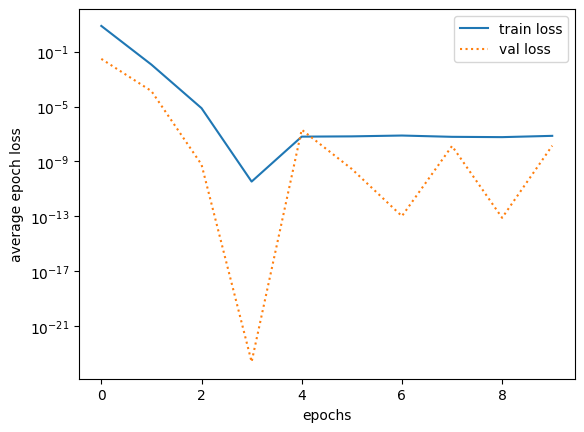

In [24]:
plot_train_and_val_loss(avg_epoch_train_losses,
                        avg_epoch_val_losses
                        )

In [25]:
# Accessing all model parameters (including coefficients)
all_parameters = list(sindy_model.parameters())

# Accessing the coefficient matrix (excluding the boolean mask)
coefficients_matrix = all_parameters[1].detach().numpy()

# Accessing the boolean mask
boolean_mask = sindy_model.mask.detach().numpy()

# Printing the results
#print("All Parameters (including coefficients):", all_parameters)
print("Coefficients:", coefficients_matrix)
print("Boolean Mask:", boolean_mask)

Coefficients: [[ 1.9305513e-05  1.7759052e-05 -6.2408981e-07 -9.9998629e-01
  -3.3139131e-05  3.5781850e-06  2.0882044e-05  7.0211252e-05
  -2.7006936e-05 -8.0701604e-05]]
Boolean Mask: [[ True  True  True  True  True  True  True  True  True  True]]


1.3. Implementing the thresholding

In [26]:
def sequential_thresholding(coefficients, mask, epoch, threshold_a, interval):
    # Apply thresholding every 'interval' epochs
    # if interval > 0 and (epoch % interval == 0):
    # Identify small coefficients
    small_coefficients = torch.abs(coefficients) < threshold_a

    # Zero out small coefficients
    with torch.no_grad():
        # Zero out small coefficients
        coefficients[small_coefficients] = 0.0

    # Update the mask for coefficients smaller than a
    mask[small_coefficients] = False

    # # Set requires_grad to False for zeroed-out coefficients
    # coefficients[coefficients == 0.0].requires_grad_(False)

    return coefficients, mask

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001, thresholding=None, threshold_a=1e-7, interval=10):

    print("interval value is:", interval)
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Apply Sequential Thresholding (ST) if specified
        if thresholding == "sequential":
            print(f"epoch % interval is: {epoch % interval}")
            if (epoch % interval == 0):
              print("now coefficients will be set to zero")
              sequential_thresholding(model.coefficients, model.mask, epoch, threshold_a, interval)

        # Log coefficient values
        print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        print((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy())
        print("boolean matrix:")
        print(model.mask.detach().numpy())
        coefficient_values_over_time.append(coefficients_snapshot)


        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')

    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time

In [39]:
# training the model
input_size = 10
output_size = 1

# Create SINDy model
sindy_model_ST = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time = train_and_validate_sindy(sindy_model_ST,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005,
                                                                                                      thresholding="sequential",
                                                                                                      threshold_a=0.00001,
                                                                                                      interval=2)


interval value is: 2
epoch % interval is: 1
coefficients right now:
[[-0.01249702 -0.28336358  0.004665   -0.44356024  0.00388543  0.0145484
  -0.00388435  0.00671805 -0.01748152 -0.00175902]]
boolean matrix:
[[ True  True  True  True  True  True  True  True  True  True]]
Epoch 1/10, Avg. Training Loss: 7.378367710542523, Avg. Validation Loss: 0.02910797455731093
epoch % interval is: 0
now coefficients will be set to zero
coefficients right now:
[[-4.8909400e-04 -2.0239417e-02  3.1279700e-04 -9.6104860e-01
   2.3123703e-04  2.9011646e-03 -2.9558260e-03  2.0180098e-04
  -4.8957490e-03  4.2392751e-03]]
boolean matrix:
[[ True  True  True  True  True  True  True  True  True  True]]
Epoch 2/10, Avg. Training Loss: 0.011188932365955105, Avg. Validation Loss: 0.00014453130398786623
epoch % interval is: 1
coefficients right now:
[[-2.6870815e-05 -3.3810722e-06  9.7207055e-07 -9.9999481e-01
   4.2887008e-05  4.3222349e-06 -2.1617436e-04  3.1058528e-07
   4.2492716e-06  2.6756260e-04]]
boolean 

In [40]:
# Accessing all model parameters (including coefficients)
all_parameters = list(sindy_model_ST.parameters())

# Accessing the coefficient matrix (excluding the boolean mask)
coefficients_matrix = all_parameters[1].detach().numpy()

# Accessing the boolean mask
boolean_mask = sindy_model_ST.mask.detach().numpy()

# Printing the results
#print("All Parameters (including coefficients):", all_parameters)
print("Coefficients:", coefficients_matrix)
print("Boolean Mask:", boolean_mask)

Coefficients: [[ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]]
Boolean Mask: [[False False False  True False False False False False False]]


TO DO:

1. oh now I understand, I need to mask the coefficients and then use them! oh this makes sense. I get it now.

2. Implement PTAT.

# Everything below is not important

In [23]:
# import numpy as np
# from scipy.integrate import odeint
# import matplotlib.pyplot as plt

# # Define the ODE system
# def my_ode(y, t):
#     dydt = -2 * y  # Example: simple exponential decay
#     return dydt

# # Initial condition
# y0 = 1.0

# # Time points
# t = np.linspace(0, 5, 101)

# # Solve the ODE using odeint
# solution = odeint(my_ode, y0, t)

# # Plot the solution
# plt.plot(t, solution)
# plt.xlabel('Time')
# plt.ylabel('y(t)')
# plt.title('ODE Solution')
# plt.show()
